In [1]:
import sys
import glob
import os
import re
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline

# Creates and Readdir Latencies

IOError: File scale-clients/1client/ls_runtimes does not exist

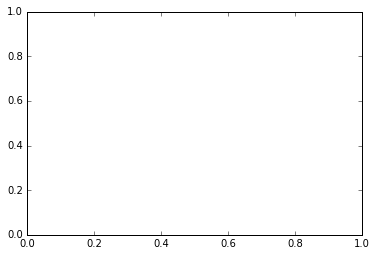

In [4]:
def plot_runtime(ax, f):
    df = pd.read_table(f, sep=',')
    df['y'] = 0
    
    for index, row in df.iterrows():
        h, m, s = row["delta"].split(':')
        df['y'][index] = 60.0*60.0*float(h) + 60.0*float(m) + float(s)
    ax.plot(df['nfiles'], df['y'], markersize=10, linewidth=3.0)
    ax.set_xscale('log')
    
fig = plt.figure()
ax = fig.add_subplot(111)
plot_runtime(ax, "scale-clients/1client/ls_runtimes")

In [8]:
mdss = []
labels = []
mdss.append("issdm-12")
print mdss

# setup the MDS labels for graphing
for i in range(0, len(mdss)):
    labels.append("MDS" + str(i))
    
# graph settings
PLT_ARGS = {'linewidth': 2.0}
PNG_ARGS = {'dpi': 300, 'bbox_inches': 'tight'}
PARSEARG = {'engine': 'python', 'header': None, 'sep': (",|:"), 'skiprows': 13}

def mds_label(fname, metric):
    return "blah"
    rank = os.path.basename(fname)
    rank = rank.strip('.out').strip(metric+'-')
    rank = mdss.index(rank)
    site = os.path.dirname(fname)
    site = os.path.dirname(site)
    return "MDS"+str(rank)+"-"+site

def site_label(fname):
    return os.path.dirname(fname)

# read in traces and find first timestamp
def read_traces(fnames, metric):
    min_ts = 1.7976931348623157e+308
    PARSEARG['names'] = ("seconds", metric)
    traces = {}
    for f in fnames:
        try:                                         # in case trace has no data
            traces[f] = pd.read_table(f, **PARSEARG) # read with parser specified by PARSE_ARGS
            if traces[f]['seconds'][0] < min_ts:     # find minimum timestamp
                min_ts = traces[f]['seconds'][0]
        except:
            pass
    return traces, min_ts

# plot the metrics over time in MDS rank order
def plot_whisperdb(fnames):
    if 'cpu' in fnames[0]: metric = 'cpu'
    else: metric = 'reply'
    
    prev_df = None
    traces, min_ts = read_traces(fnames, metric)
    #ax = plt.figure().add_subplot(111)
    for mds in mdss:
        for f in traces:
            if mds in f:
                t = traces[f]
                t = t[t.seconds != 0]    # ignore timestamps carbon did't get any metrics 
                if metric == 'reply':
                    t['shifted'] = t['reply'].shift(1)
                else:
                    t['shifted'] = 0
                #ax.plot(t['seconds'] - min_ts,   # slide x axis to start at 0
                #        t[metric] - t['shifted'],               # plot the raw cpu 
                #        label=mds_label(f, metric),         
                #        **PLT_ARGS)
                if prev_df is None:
                    prev_df = pd.DataFrame()
                    prev_df[metric] = t[metric] - t['shifted']
                    prev_df['seconds'] = t['seconds'] - min_ts
                else:
                    prev_df[metric] = prev_df[metric] + t[metric] - t['shifted']

    ax = plt.figure().add_subplot(111)
    ax.plot(prev_df['seconds'], prev_df[metric], **PLT_ARGS)
    #print prev_df.head()
    ax.legend(loc='upper left')
    ax.legend(bbox_to_anchor=(1.7, 1.05))
    return ax

['issdm-12']


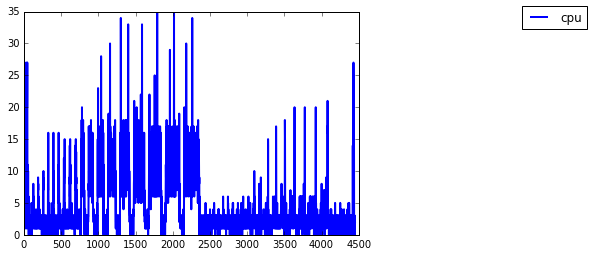

In [9]:
fnames = sorted(glob.glob("readdir-zoom-cpu/utilization/issdm-12.out"))
ax = plot_whisperdb(fnames)

In [12]:
creates = pd.read_table("readdir-zoom-cpu/creates", sep=" ", index_col=False)
creates.head()
creates['x'] = 0
for index, row in creates.iterrows():
    h, m, s = row['#time'].split(':')
    if index % 100 == 0:
        print index
    creates['x'][index] = 60.0*60.0*float(h) + 60.0*float(m) + float(s)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2294


,time,nrequests,latency,average,x
0,05:50:43,0,NaN,0.000000,21043
1,05:50:44,922,0.114463,0.000000,21044
2,05:50:45,78,1.900393,0.000000,21045
3,05:50:46,0,NaN,1.900393,21046
4,05:50:47,0,NaN,1.900393,21047


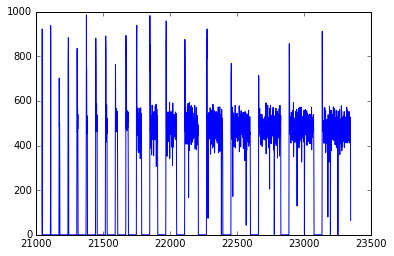

In [15]:
readdir = pd.read_table("readdir-zoom/readdir", sep=" ", index_col=False)
readdir.head()
readdir['x'] = 0
for index, row in readdir.iterrows():
    h, m, s = row['#time'].split(':')
    if index % 100 == 0:
        print index
    readdir['x'][index] = 60.0*60.0*float(h) + 60.0*float(m) + float(s)
print len(readdir.index)   

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1660


,#time,nrequests,latency,average,x
0,06:30:13,0,NaN,0.000000,23413
1,06:30:14,1,14.600705,0.000000,23414
2,06:30:15,0,NaN,14.600705,23415
3,06:30:16,0,NaN,14.600705,23416
4,06:30:17,0,NaN,14.600705,23417


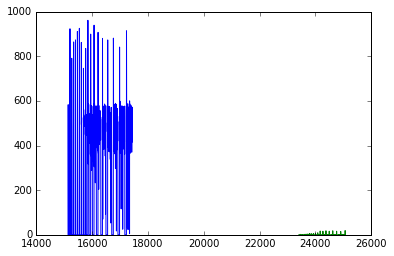

In [16]:
ax = plt.figure().add_subplot(111)
ax.plot(creates['x'], creates['nrequests'])
ax.plot(readdir['x'], readdir['nrequests'])
readdir.head()

(0, 200)

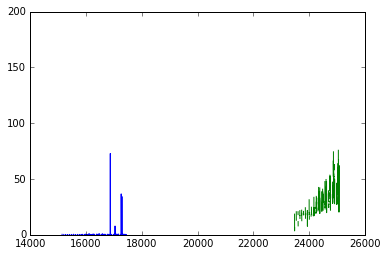

In [17]:
ax = plt.figure().add_subplot(111)
ax.plot(creates['x'], creates['latency'])
ax.plot(readdir['x'], readdir['latency'])
ax.set_ylim(0, 200)